<a href="https://colab.research.google.com/github/Zshoham/YHB/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [ ]:
def reshape_data(data):
  images = list()
  for d in data:
      image = np.zeros((32,32,3), dtype=np.uint8)
      image[...,0] = np.reshape(d[:1024], (32,32)) # Red channel
      image[...,1] = np.reshape(d[1024:2048], (32,32)) # Green channel
      image[...,2] = np.reshape(d[2048:], (32,32)) # Blue channel
      images.append(image)
  return np.array(images)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import requests
import tarfile
import os

if not os.path.isdir('cifar-100-python'):
  data = requests.get("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")
  with open("cifar100.tar.gz", 'wb') as f:
      f.write(data.content) 

  tar = tarfile.open("cifar100.tar.gz", "r:gz")
  tar.extractall()
  tar.close()

cifar_train = unpickle("cifar-100-python/train")
cifar_test = unpickle("cifar-100-python/test")

train_data = reshape_data(cifar_train[b'data'])
train_labels = np.array(cifar_train[b'coarse_labels'])
train_fine_labels = np.array(cifar_train[b'fine_labels'])


test_data = reshape_data(cifar_test[b'data'])
test_labels = np.array(cifar_test[b'coarse_labels'])
test_fine_labels = np.array(cifar_test[b'fine_labels'])

meta = unpickle("cifar-100-python/meta")
label_names = meta[b'coarse_label_names']
fine_label_names = meta[b'fine_label_names']

label_names = np.array(list(map(lambda bstr: bstr.decode("utf-8"), label_names)))
fine_label_names = np.array(list(map(lambda bstr: bstr.decode("utf-8"), fine_label_names)))

# Data Exploration

In [ ]:
import math
def plot_images(images, labels=None, fig_size=(10,10)):
  size = int(math.sqrt(len(images)))
  fig, aux = plt.subplots(size, size, figsize=fig_size)
  aux = aux.flatten()
  for i in range(0,aux.size):
    aux[i].imshow(images[i])
    if labels is not None:
      aux[i].title.set_text(labels[i])

In [ ]:
def get_label_name(label_id):
  return fine_label_names[label_id]

def get_label_id(label_name):
  return np.where(fine_label_names == label_name)[0][0]

The dataset is split into two sets, training data and test data. All images are 32x32 with RGB color channals. There are 2 types of labels, "high level" categories of which there are 20, and "low level" categories of which there are 100. Each of the 100 low level categories belongs to a high level category. We start by observing the number of samples in each set, and the distribution of labels.

number of high level labels: 20
number of low level labels: 100
number of training imeges: 50000
number of testing imeges: 10000


<BarContainer object of 100 artists>

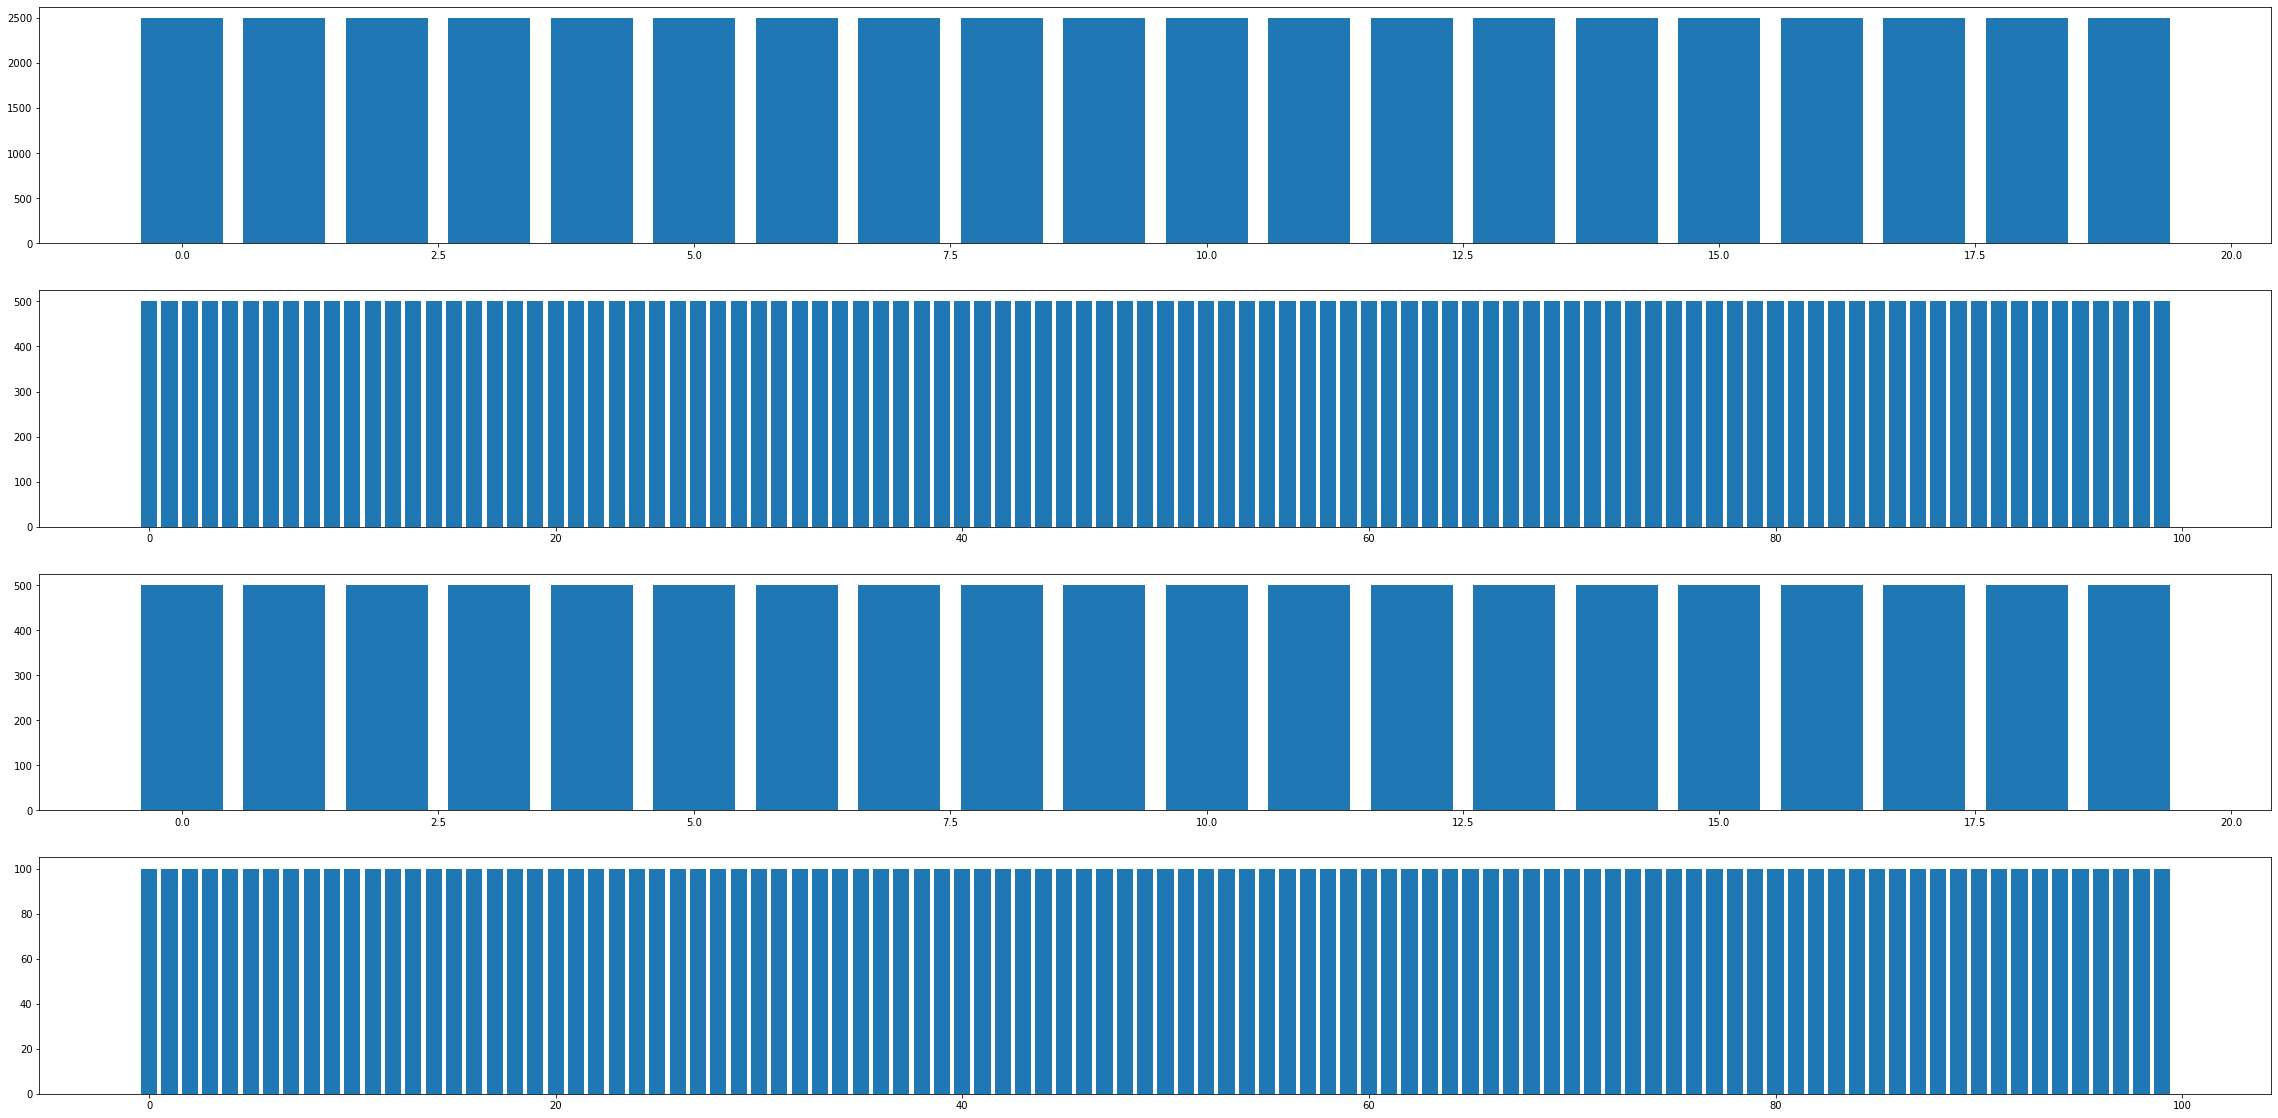

In [ ]:
print("number of high level labels: " + str(label_names.size))
print("number of low level labels: " + str(fine_label_names.size))

print("number of training imeges: " + str(len(train_data)))
print("number of testing imeges: " + str(len(test_data)))

train_lbl, train_lbl_counts = np.unique(train_labels, return_counts=True)
train_fine_lbl, train_fine_lbl_counts = np.unique(train_fine_labels, return_counts=True)

test_lbl, test_lbl_counts = np.unique(test_labels, return_counts=True)
test_fine_lbl, test_fine_lbl_counts = np.unique(test_fine_labels, return_counts=True)

fig, aux = plt.subplots(4, figsize=(40,20))
aux[0].bar(train_lbl, train_lbl_counts, label="training high level label distribution")
aux[1].bar(train_fine_lbl, train_fine_lbl_counts, label="training low level label distribution")
aux[2].bar(test_lbl, test_lbl_counts, label="testing high level label distribution")
aux[3].bar(test_fine_lbl, test_fine_lbl_counts, label="testing low level label distribution")


As we can see from the plots above, the label distribution in the data is perfectly uniform, each high level label having 2500 training examples and 500 testing examples, while each low level label has 500 training examples and 100 testing examples.

Next Lets take a look at the labels and images themselves. First we show an example of 25 images with their labels. We can immediatly see two things:
 * The big veriaty of images and labels available
 * How liitle image data available for each image, many images are bearly recognizable even to humans.

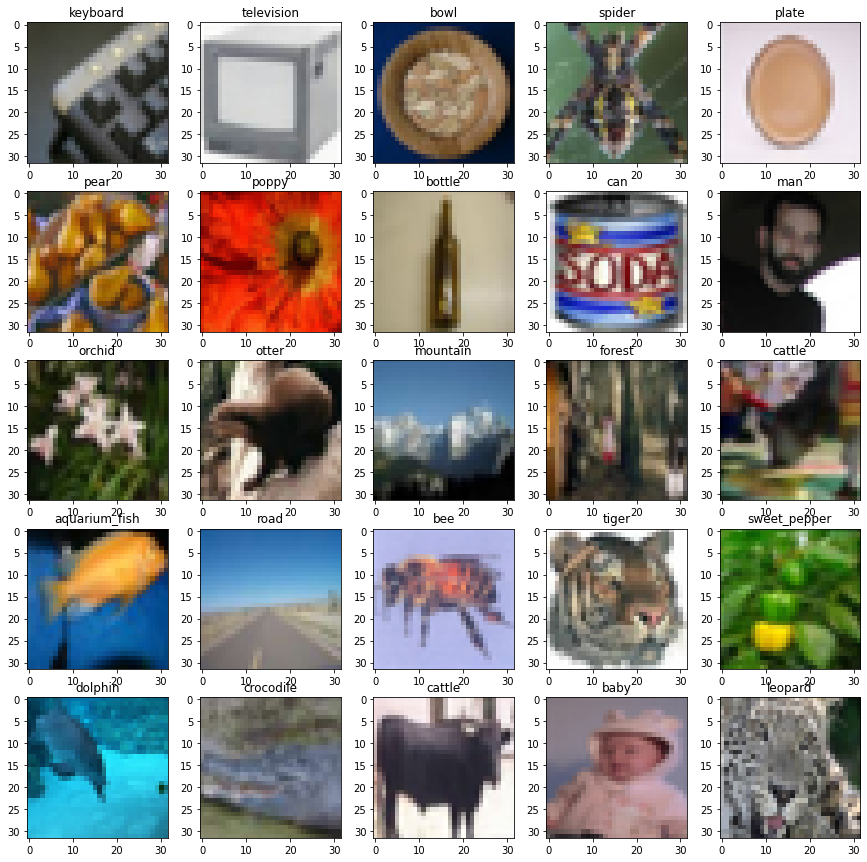

In [ ]:
example_indecies = np.random.choice(np.arange(len(train_labels)), 25, replace=False)
plot_images(train_data[example_indecies], fine_label_names[train_fine_labels[example_indecies]], (15,15))

Next lets take a look at the labels we are going to use (we'll only use the low level labels for our models)

In [ ]:
print(fine_label_names)

['apple' 'aquarium_fish' 'baby' 'bear' 'beaver' 'bed' 'bee' 'beetle'
 'bicycle' 'bottle' 'bowl' 'boy' 'bridge' 'bus' 'butterfly' 'camel' 'can'
 'castle' 'caterpillar' 'cattle' 'chair' 'chimpanzee' 'clock' 'cloud'
 'cockroach' 'couch' 'crab' 'crocodile' 'cup' 'dinosaur' 'dolphin'
 'elephant' 'flatfish' 'forest' 'fox' 'girl' 'hamster' 'house' 'kangaroo'
 'keyboard' 'lamp' 'lawn_mower' 'leopard' 'lion' 'lizard' 'lobster' 'man'
 'maple_tree' 'motorcycle' 'mountain' 'mouse' 'mushroom' 'oak_tree'
 'orange' 'orchid' 'otter' 'palm_tree' 'pear' 'pickup_truck' 'pine_tree'
 'plain' 'plate' 'poppy' 'porcupine' 'possum' 'rabbit' 'raccoon' 'ray'
 'road' 'rocket' 'rose' 'sea' 'seal' 'shark' 'shrew' 'skunk' 'skyscraper'
 'snail' 'snake' 'spider' 'squirrel' 'streetcar' 'sunflower'
 'sweet_pepper' 'table' 'tank' 'telephone' 'television' 'tiger' 'tractor'
 'train' 'trout' 'tulip' 'turtle' 'wardrobe' 'whale' 'willow_tree' 'wolf'
 'woman' 'worm']


obviously some labels are more similar then others, lets take a look at some examples.

In [ ]:
def get_label_examples(data, label, size=10):
  lbl_indx = np.arange(len(train_fine_labels))
  lbl_filter = train_fine_labels == get_label_id(label)
  indecies = np.random.choice(lbl_indx[lbl_filter], size, replace=False)
  return data[indecies]

Here we see some images of apples and lions ( two apples above and two lions below), though some images are a little hard to identify, the two classes are easily seprebale.

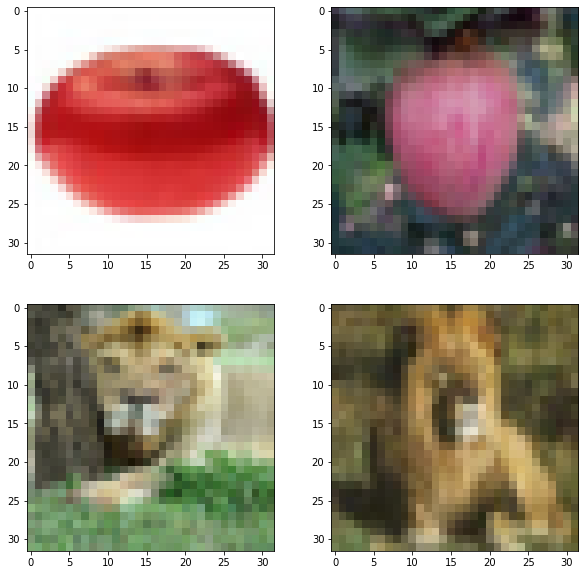

In [ ]:
apple_examples = get_label_examples(train_data, 'apple', size=2)
bee_examples = get_label_examples(train_data, 'lion', size=2)
examples = np.concatenate((apple_examples, bee_examples))
plot_images(examples)

Here we see some images of willow trees and oak trees ( two willow trees above and two oak trees below), Those are much harder to seperate, expecially with the very low resultion of the images

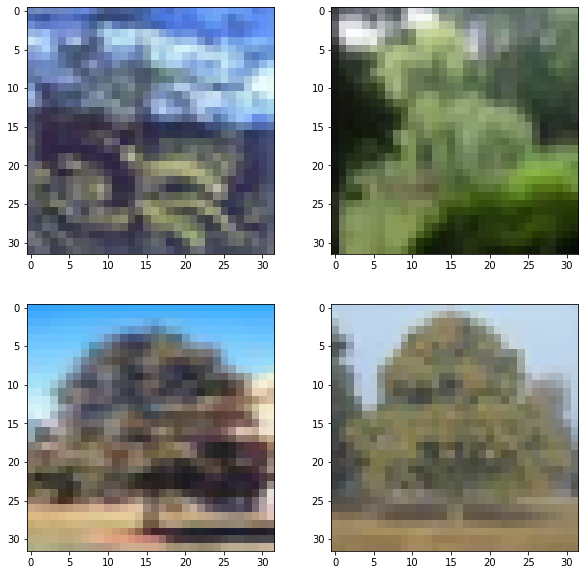

In [ ]:
apple_examples = get_label_examples(train_data, 'willow_tree', size=2)
bee_examples = get_label_examples(train_data, 'oak_tree', size=2)
examples = np.concatenate((apple_examples, bee_examples))
plot_images(examples)

After seeing the data, we can start preparing it for use in our models. sience we are going to be using neural networks, the data should be in the (0-1) range, so we'll start by normalizing the data by deviding all the integer values by 255. We plot 25 random images again to make sure that the images are preserved after the normalization.

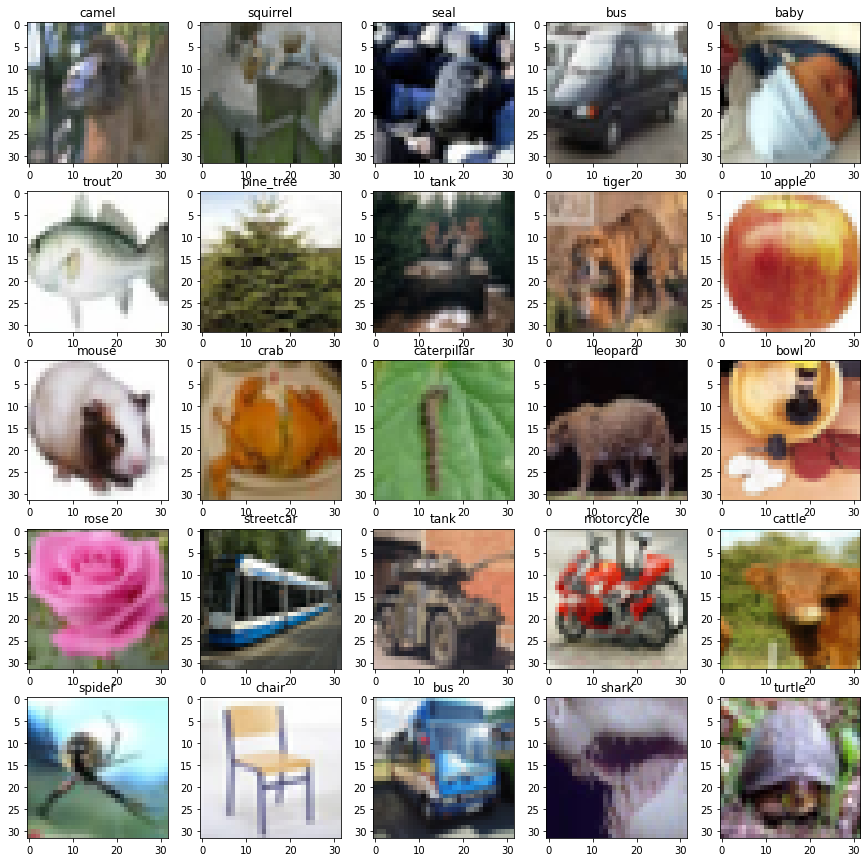

In [ ]:
train_data = train_data.astype(float) / 255
test_data = test_data.astype(float) / 255
example_indecies = np.random.choice(np.arange(len(train_labels)), 25, replace=False)
plot_images(train_data[example_indecies], fine_label_names[train_fine_labels[example_indecies]], (15,15))

Next is data augmentation, because the dataset is so well constructed we opted to not add additional data at this stage, and insted augment some of the images in place, if we will later find out that we did not have enough data to train our model, we will consider adding additional data through autmentation. We apply the augmentation on all the data equally (for example 2% of all images regardless of class will have noise added to them)

In [ ]:
def augment(image):
  rand = np.random.uniform()
  if rand < 0.02:
   image = image + np.random.normal(0, 0.03, image.shape)
  
  # if rand < 0.025 and rand > 0.02:
  #   image = tf.image.random_brightness(image, 0.2)

  # if rand < 0.03 and rand > 0.025:
  #   image = tf.image.random_contrast(image, lower=0.5, upper=1)
  
  # if rand < 0.035 and rand > 0.03:
  #   image = tf.image.random_saturation(image, lower=0.5, upper=1)

  return image

aug_train = np.array([augment(img) for img in train_data])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator()

50000

# Simple Model



In [ ]:
!pip install wandb -qqq
import wandb
!wandb login

wandb: Currently logged in as: zshoham (use `wandb login --relogin` to force relogin)


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback

def evaluate(model_gen):
  wandb.init(
    project="dl_assignment1",
    group="simple_model",
    config={
      "data_augmentation": True,
      "epochs": 20,
      "batch_size": 100,  
      "architecture": "Shallow CNN",
  })
  config = wandb.config

  acc_per_fold = []
  loss_per_fold = []

  data = np.concatenate((aug_train, test_data), axis=0)
  labels = np.concatenate((train_fine_labels, test_fine_labels), axis=0)
  kfold = KFold(n_splits=5, shuffle=True)
  fold_num = 1
  for train, test in kfold.split(data, labels):
    model = model_gen()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(data[train], labels[train],
              batch_size=config.batch_size,
              epochs=config.epochs,
              verbose=1,
              callbacks=[WandbCallback()])
    scores = model.evaluate(data[test], labels[test], verbose=0)
    print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_num = fold_num + 1
  
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')
  wandb.finish()

In [ ]:
model_gen = lambda: keras.Sequential(
    [
      keras.Input((32,32,3)),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPool2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.AveragePooling2D(),
      layers.Flatten(),
      layers.Dense(100, activation='softmax')
    ]
)
evaluate(model_gen)

wandb: Currently logged in as: zshoham (use `wandb login --relogin` to force relogin)


Epoch 1/20
480/480 [==============================] - 1s 3ms/step - loss: 3.8316 - accuracy: 0.1322
Epoch 2/20
480/480 [==============================] - 1s 3ms/step - loss: 3.2043 - accuracy: 0.2438
Epoch 3/20
480/480 [==============================] - 1s 3ms/step - loss: 2.9498 - accuracy: 0.2903
Epoch 4/20
480/480 [==============================] - 1s 3ms/step - loss: 2.7929 - accuracy: 0.3239
Epoch 5/20
480/480 [==============================] - 1s 3ms/step - loss: 2.6744 - accuracy: 0.3453
Epoch 6/20
480/480 [==============================] - 1s 3ms/step - loss: 2.5612 - accuracy: 0.3685
Epoch 7/20
480/480 [==============================] - 1s 3ms/step - loss: 2.4694 - accuracy: 0.3894
Epoch 8/20
480/480 [==============================] - 1s 3ms/step - loss: 2.3905 - accuracy: 0.4028
Epoch 9/20
480/480 [==============================] - 1s 3ms/step - loss: 2.3163 - accuracy: 0.4192
Epoch 10/20
480/480 [==============================] - 1s 3ms/step - loss: 2.2526 - accuracy: 0.4333

epoch,19
loss,1.82061
accuracy,0.52719
_step,99
_runtime,164
_timestamp,1605721906


epoch,▁▂▃▄▅▅▇▇▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
loss,█▅▄▃▂▂▂▁█▅▃▃▂▂▁▁█▄▄▃▂▂▂▁█▄▃▃▂▂▁▁▆▄▃▃▂▂▁▁
accuracy,▁▄▅▆▆▇▇█▁▄▅▆▇▇██▁▄▅▆▆▇▇█▁▄▆▆▇▇██▃▄▆▆▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


In [ ]:
# model = keras.Sequential(
#     [
#      keras.Input((32,32,3)),
#      layers.Conv2D(32, 5, activation='relu'),
#      layers.Conv2D(64, 5, activation='relu'),
#      layers.Conv2D(128, 5, activation='relu'),
#      layers.Conv2D(32, 1, activation='relu'),
#      layers.BatchNormalization(),
#      layers.MaxPool2D(),
#      layers.Conv2D(64, (1,3), activation='relu'),
#      layers.Conv2D(64, (3,1), activation='relu'),
#      layers.Conv2D(128, 1, activation='relu'),
#      layers.AveragePooling2D(),
#      layers.Flatten(),
#      layers.Dropout(0.5),
#      layers.Dense(100, activation='softmax')
#      ]
# )

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 64)        51264     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 128)       204928    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 20, 20, 32)        4128      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 8, 64)        

In [ ]:
# model.fit(x=aug_train, y=train_labels, batch_size=config.batch_size, epochs=config.epochs, , verbose=1)

SyntaxError: ignored